# K-Nearest Neighbor

---

<center>
Authors:
<ul>
<li> Valentin Rieu </li>
<li> Amgad Khalil </li>
</ul>
</center>

---

## Imports

In [242]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import sklearn
import seaborn as sns
from sklearn.model_selection import (train_test_split, cross_val_score)
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, mean_squared_error, mean_absolute_error
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings(action='ignore', category=FutureWarning)

## Initialization of dataset + training/testing set

In [243]:
n_features = 21
features = [f'attr{str(i)}' for i in range(1, n_features + 1)]
features.append('c')
ds = pd.read_csv('../waveform/waveform.data', names=features)

In [244]:
ds.describe()

attr1        attr2        attr3        attr4        attr5  \
count  5000.000000  5000.000000  5000.000000  5000.000000  5000.000000   
mean      0.005144     0.338746     0.672438     0.991610     1.310888   
std       1.010130     1.053657     1.187970     1.415239     1.678291   
min      -3.340000    -3.250000    -4.200000    -3.840000    -3.480000   
25%      -0.680000    -0.372500    -0.150000    -0.020000     0.037500   
50%       0.010000     0.340000     0.660000     0.940000     1.120000   
75%       0.690000     1.050000     1.460000     1.970000     2.540000   
max       3.940000     3.880000     4.720000     5.750000     6.500000   

             attr6        attr7        attr8        attr9       attr10  ...  \
count  5000.000000  5000.000000  5000.000000  5000.000000  5000.000000  ...   
mean      1.997306     2.661806     2.659228     2.672086     2.988668  ...   
std       1.814187     2.015774     1.746067     1.663277     1.531506  ...   
min      -2.760000    -3.320000    -3.520000    -3.380000    -1.790000  ...   
25%       0.590000     1.110000     1.390000     1.470000     1.880000  ...   
50%       1.860000     2.500000     2.720000     2.810000     3.000000  ...   
75%       3.340000     4.210000     3.940000     3.940000     4.080000  ...   
max       7.620000     8.760000     7.840000     7.900000     7.630000  ...   

            attr13       attr14       attr15       attr16       attr17  \
count  5000.000000  5000.000000  5000.000000  5000.000000  5000.000000   
mean      2.678908     2.648632     2.647668     2.000504     1.335032   
std       1.651588     1.760113     2.018768     1.810684     1.669949   
min      -2.610000    -2.820000    -2.560000    -2.990000    -3.560000   
25%       1.480000     1.360000     1.120000     0.640000     0.070000   
50%       2.830000     2.700000     2.490000     1.820000     1.200000   
75%       3.932500     3.980000     4.182500     3.330000     2.532500   
max       7.500000     7.750000     8.720000     7.860000     6.740000   

            attr18       attr19       attr20       attr21            c  
count  5000.000000  5000.000000  5000.000000  5000.000000  5000.000000  
mean      1.000622     0.661482     0.357300    -0.021378     1.007800  
std       1.412815     1.197326     1.081337     0.997064     0.818946  
min      -4.080000    -3.500000    -3.570000    -3.880000     0.000000  
25%      -0.010000    -0.180000    -0.350000    -0.690000     0.000000  
50%       0.940000     0.620000     0.350000    -0.030000     1.000000  
75%       1.960000     1.470000     1.072500     0.660000     2.000000  
max       6.200000     5.280000     4.650000     4.010000     2.000000  

[8 rows x 22 columns]

In [245]:
ds.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 22 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   attr1   5000 non-null   float64
 1   attr2   5000 non-null   float64
 2   attr3   5000 non-null   float64
 3   attr4   5000 non-null   float64
 4   attr5   5000 non-null   float64
 5   attr6   5000 non-null   float64
 6   attr7   5000 non-null   float64
 7   attr8   5000 non-null   float64
 8   attr9   5000 non-null   float64
 9   attr10  5000 non-null   float64
 10  attr11  5000 non-null   float64
 11  attr12  5000 non-null   float64
 12  attr13  5000 non-null   float64
 13  attr14  5000 non-null   float64
 14  attr15  5000 non-null   float64
 15  attr16  5000 non-null   float64
 16  attr17  5000 non-null   float64
 17  attr18  5000 non-null   float64
 18  attr19  5000 non-null   float64
 19  attr20  5000 non-null   float64
 20  attr21  5000 non-null   float64
 21  c       5000 non-null   int64  
dtype

We can notice that the dataset is already clean: no `NaN` values

[]

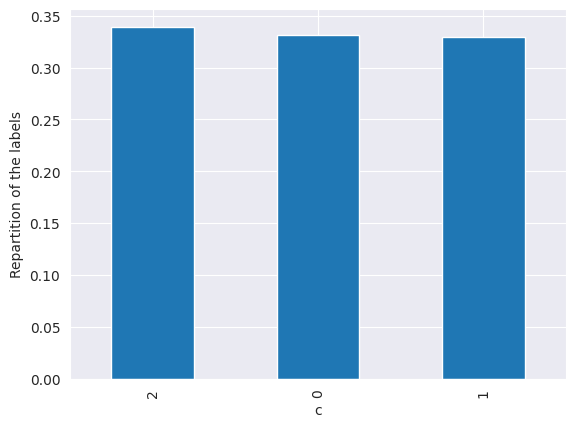

In [246]:
ds['c'].value_counts(normalize=True).plot(kind='bar')
plt.ylabel('Repartition of the labels')
plt.plot()

In [247]:
y = ds['c'].copy()
X = ds.iloc[:, :n_features].copy()          

We will split training data and test data now, to avoid overfitting and bias. Ratio 4:1 for the training set

Undersampling methods (such as the CNN) will be only performed on the training set. While dimensionality reducing methods
such as PCAs and LDA will need to perform a computation of the eigenvalues on the training set and only do the corresponding transformation on their test sets.

the test set will be left untouched and unused until the end of the transformation pipeline

In [248]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42) # A static random state for troubleshooting

We will make a copy of the training set for the various modification we will perform, to then perform analysis over them
It will be as follows:
- `train_control`: no data reduction, no oversampling
- `train_cond`: training set modified by the Condensed Nearest Neighbor
- `X_train_pca`: training set modified by a PCA
- `X_train_lda`: training set modified by an LDA

In [249]:
X_train_control, y_train_control = X_train.copy(), y_train.copy()
X_train_cond, y_train_cond = X_train.copy(), y_train.copy()
X_train_pca, y_train_pca = X_train.copy(), y_train.copy()
X_test_pca, y_test_pca = X_test.copy(), y_test.copy()
X_train_lda, y_train_lda = X_train.copy(), y_train.copy()
X_test_lda, y_test_lda = X_test.copy(), y_test.copy()

---

Organization of the tasks:
1. Find the best k using cross-validation (both on the original dataset and the condensed dataset)
2. Perform Data Reduction (Reduced NN, Condensed NN),
3. Comparison between the original dataset and the condensed dataset with a 1NN
5. Perform PCA and LDA
6. Compare the performances of a tuned k-NN over control/PCA/LDA

---



## Tune the hyperparameter k

Optimal Bayes Classification rate = 86% accuracy

We also know that a good estimator for the hyperparameter k is $\sqrt{|S|}$

In [250]:
theoretical_k = round(np.sqrt(X_train_control.shape[0]))
print(theoretical_k)

63


In [251]:
def tune(X, y, k_min, k_max):
    assert k_min <= k_max, f'k_min should be less than k_max, got {k_min} while k_max = {k_max}'
    assert k_min > 0, f'k_min should be greater than 0, got {k_min} '
    print(X.shape)
    k_l = np.arange(k_min, k_max+1, 1)
    acc = [0]
    std = [0]
    
    for k in k_l:
        cross_val = cross_val_score(KNeighborsClassifier(n_neighbors=k), X=X, y=y, cv=10, scoring='accuracy')
        print(np.mean(cross_val))
        acc.append(np.mean(cross_val))
        std.append(np.std(cross_val))
        
    return acc, std

In [252]:
acc, std = tune(X_train, y_train, 1, 100)

(4000, 21)
0.77525
0.76475
0.8052499999999998
0.79325
0.8115
0.8077500000000001
0.8225000000000001
0.8220000000000001
0.83375
0.8314999999999999
0.8317500000000001
0.836
0.8387499999999999
0.8365
0.8387499999999999
0.842
0.8412499999999999
0.843
0.8400000000000001
0.84375
0.84475
0.8474999999999999
0.8472500000000001
0.8474999999999999
0.8452500000000001
0.84825
0.8494999999999999
0.85175
0.8467500000000001
0.8494999999999999
0.8450000000000001
0.84925
0.8465
0.8504999999999999
0.8460000000000001
0.851
0.8487500000000001
0.85125
0.85
0.8505
0.8497499999999999
0.8524999999999998
0.85
0.85125
0.85
0.85125
0.8504999999999999
0.8547499999999999
0.8494999999999999
0.8532500000000001
0.8497499999999999
0.85125
0.8497499999999999
0.8539999999999999
0.851
0.853
0.8504999999999999
0.8530000000000001
0.853
0.8545
0.8532499999999998
0.8549999999999999
0.853
0.8554999999999999
0.8545
0.8557500000000001
0.8564999999999999
0.8564999999999999
0.8557500000000001
0.85825
0.8547499999999999
0.857
0.8557

In [253]:
print(acc.index(max(acc)))
print(max(acc))

70
0.85825


In [254]:
acc_plus = np.add(acc, std)
acc_plus[acc_plus > 0.86] = 0.86
acc_minus = np.subtract(acc, std)

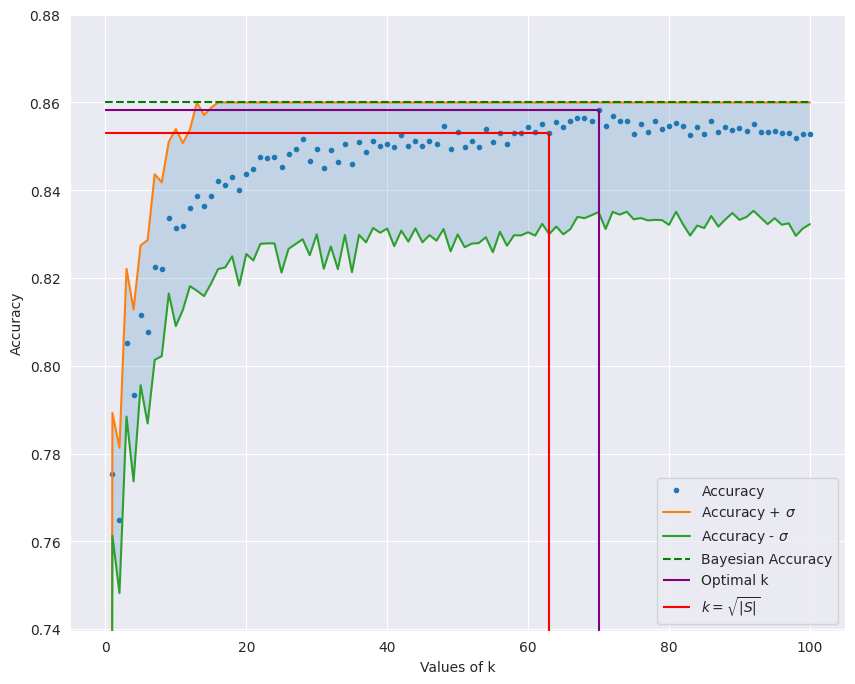

In [255]:
fig, ax = plt.subplots(figsize=(10, 8))
xaxis = list(range(0, 101))
ax.plot(xaxis, acc, '.', label='Accuracy')
ax.plot(xaxis, acc_plus,label='Accuracy + $\sigma$')
ax.plot(xaxis, acc_minus, label='Accuracy - $\sigma$')
ax.fill_between(xaxis, acc_plus, acc_minus, alpha=0.2)
ax.hlines(xmin=0, xmax=100 ,y=0.86, color='green',linestyle='--', label='Bayesian Accuracy')
ax.hlines(xmin=0, xmax=acc.index(max(acc)), y=max(acc), color='purple')
ax.hlines(xmin=0, xmax=theoretical_k, y=acc[theoretical_k], color='r')
ax.vlines(ymin = min(acc[1:]) - max(std[1:]), ymax=max(acc), x=acc.index(max(acc)), color='purple', label='Optimal k')
ax.vlines(ymin = min(acc[1:]) - max(std[1:]), ymax=acc[theoretical_k], x=theoretical_k, label='$k = \sqrt{|S|}$', color='r')
plt.ylim(min(acc[1:]) - max(std[1:]), 0.88)
plt.xlabel('Values of k')
plt.ylabel("Accuracy")
plt.legend()
plt.show()

---

## Data Reduction

Since the KNN performance is highly impact by the size of the dataset, we will perform a data reduction algorithm (CNN) to ease the time taken by the KNN, while trying to conserve the accuracy of the model.

Each point can be either:
1. A prototype (points needed for accurate classification),
2. An outlier
3. An absorbed point (point correctly classified by prototypes)

Algorithm is as follows:

1. Find the outlier (incorrectly classified by a 1NN) and remove them from the dataset
2. Take a random point, add it to a storage dataset
3. Classify the dataset with the storage dataset. If a point is correctly classified, remove it from the dataset. If a poiint is missclassified, add it to the storage.

In [256]:
def reduce(x_1, y_1, x_2, y_2, model=None):
    if model is None:
        model = KNeighborsClassifier(n_neighbors=1)
    model.fit(x_1, y_1)
    y_pred = model.predict(x_2)
    miss = y_pred != y_2
    tot = np.sum(miss)
    return tot, x_2[~miss], y_2[~miss]

In [257]:
def remove_outliers(X, y, seed=None):
    if seed is None:
        seed = 42
    x1, x2, y1, y2 = train_test_split(X, y, test_size=0.5, random_state=seed)
    stabilization = False
    while not stabilization:
        model = KNeighborsClassifier(n_neighbors=1)
        tot1, x1, y1 = reduce(x2, y2, x1, y1, model)
        print(f'total removed from x1: {tot1}')
        tot2, x2, y2 = reduce(x1, y1, x2, y2, model)
        print(f'total removed from x2: {tot2}')
        if tot1 + tot2 == 0:
            stabilization = True
    newX, newY = pd.concat([x1, x2], axis='index').reset_index(drop=True, inplace=False), pd.concat([y1, y2],
                                                                                                    axis='index').reset_index(
        drop=True, inplace=False)
    return newX, newY.to_frame()

In [258]:
def well_classified(X, y, model):
    return model.predict(np.asarray(X).reshape(1, -1)) == y

In [259]:
def condensate(X: pd.DataFrame, y: pd.DataFrame):
    X_storage = pd.DataFrame()
    y_storage = pd.DataFrame()
    X_cond, y_cond = X.copy(), y.copy()
    print(y_cond.columns)
    index = y_cond.groupby('c').sample(n=1).index.values
    first_y = y_cond.loc[index]
    first_X = X_cond.loc[index]
    X_storage = pd.concat([X_storage, first_X], axis='columns')
    y_storage = pd.concat([y_storage, first_y], axis='columns')
    print(X_storage)
    print(y_storage)
    X_cond = X_cond.drop(index)
    y_cond = y_cond.drop(index)
    # print(X_storage.index.values)
    total = 0
    stabilization = False
    while not stabilization:
        model = KNeighborsClassifier(n_neighbors=1)
        model.fit(X_storage.values, y_storage.values.ravel())
        stabilization = True
        for count, i in enumerate(X_cond.index.to_list()):
            # print(count, i)
            X_curr = X_cond.loc[[i]]
            y_curr = y_cond.loc[[i]]
            y_pred = model.predict(X_curr.values)
            if y_pred[0] == y_curr.values[0][0]:
                continue
            print(f'Not ok: {i} of label {y_curr.values[0][0]} but got {y_pred[0]}')
            total += 1
            X_storage = pd.concat([X_storage, X_curr], axis='rows')
            y_storage = pd.concat([y_storage, y_curr], axis='rows')
            X_cond = X_cond.drop(i)
            y_cond = y_cond.drop(i)
            stabilization = False
            break
        print(f'Total added: {total}')
    return X_storage, y_storage

In [260]:
def pipeline_cnn(X, y):
    reduced_X, reduced_y = remove_outliers(X, y)
    condensed_X, condensed_y = condensate(reduced_X, reduced_y)
    return condensed_X, condensed_y

In [261]:
X_train_cond, y_train_cond = pipeline_cnn(X_train, y_train)
print(X_train_cond.shape, y_train_cond.shape)
print(X_train.shape, y_train.shape)

total removed from x1: 446
total removed from x2: 310
total removed from x1: 15
total removed from x2: 0
total removed from x1: 0
total removed from x2: 0
Index(['c'], dtype='object')
      attr1  attr2  attr3  attr4  attr5  attr6  attr7  attr8  attr9  attr10  \
245   -0.10   1.76  -0.40   3.22   2.92   2.72   3.03   2.47   2.41    1.06   
2465   1.92   1.09   0.72   0.95   2.58   4.15   2.84   4.56   3.19    4.09   
651   -0.84  -1.49   1.01  -2.73  -0.32  -0.83   2.95   0.36   3.45    3.35   

      ...  attr12  attr13  attr14  attr15  attr16  attr17  attr18  attr19  \
245   ...    1.34    2.48    3.57    2.31    3.89   -0.13    1.12    1.98   
2465  ...    3.47    2.42    1.84    1.81    0.76    0.50   -0.10    0.67   
651   ...    3.30    4.35    2.37    2.89    0.71    1.59    3.24    0.06   

      attr20  attr21  
245     0.42    0.80  
2465    1.41    1.11  
651     1.00    1.11  

[3 rows x 21 columns]
      c
245   0
2465  1
651   2
Not ok: 1 of label 0 but got 1
Total added:

In [262]:
ds_cond = pd.concat([X_train_cond, y_train_cond], axis='columns')
ds_cond.info()

<class 'pandas.core.frame.DataFrame'>
Index: 682 entries, 245 to 3227
Data columns (total 22 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   attr1   682 non-null    float64
 1   attr2   682 non-null    float64
 2   attr3   682 non-null    float64
 3   attr4   682 non-null    float64
 4   attr5   682 non-null    float64
 5   attr6   682 non-null    float64
 6   attr7   682 non-null    float64
 7   attr8   682 non-null    float64
 8   attr9   682 non-null    float64
 9   attr10  682 non-null    float64
 10  attr11  682 non-null    float64
 11  attr12  682 non-null    float64
 12  attr13  682 non-null    float64
 13  attr14  682 non-null    float64
 14  attr15  682 non-null    float64
 15  attr16  682 non-null    float64
 16  attr17  682 non-null    float64
 17  attr18  682 non-null    float64
 18  attr19  682 non-null    float64
 19  attr20  682 non-null    float64
 20  attr21  682 non-null    float64
 21  c       682 non-null    int64  
dtypes: f

In [263]:
ds_cond.describe()

attr1       attr2       attr3       attr4       attr5       attr6  \
count  682.000000  682.000000  682.000000  682.000000  682.000000  682.000000   
mean     0.024047    0.329443    0.689384    0.953915    1.294164    1.961804   
std      1.026405    1.115488    1.196602    1.467974    1.717658    1.852953   
min     -3.250000   -2.960000   -4.200000   -2.730000   -2.600000   -2.190000   
25%     -0.650000   -0.410000   -0.097500   -0.140000    0.020000    0.512500   
50%      0.005000    0.275000    0.690000    0.820000    0.950000    1.730000   
75%      0.707500    1.097500    1.467500    1.965000    2.510000    3.370000   
max      2.840000    3.830000    4.390000    5.660000    6.500000    6.680000   

            attr7       attr8       attr9      attr10  ...      attr13  \
count  682.000000  682.000000  682.000000  682.000000  ...  682.000000   
mean     2.621188    2.662991    2.714003    3.070557  ...    2.720323   
std      2.078699    1.796675    1.775032    1.595513  ...    1.733729   
min     -1.840000   -2.150000   -2.050000   -1.140000  ...   -2.610000   
25%      1.012500    1.352500    1.412500    1.882500  ...    1.395000   
50%      2.300000    2.800000    2.880000    3.070000  ...    2.955000   
75%      4.247500    3.980000    4.107500    4.230000  ...    4.065000   
max      8.580000    7.840000    7.900000    7.160000  ...    6.750000   

           attr14      attr15      attr16      attr17      attr18      attr19  \
count  682.000000  682.000000  682.000000  682.000000  682.000000  682.000000   
mean     2.712170    2.641862    1.974311    1.316584    0.979106    0.686481   
std      1.779863    2.104579    1.830905    1.693116    1.454934    1.241540   
min     -1.970000   -1.910000   -2.700000   -3.040000   -3.190000   -3.500000   
25%      1.452500    1.042500    0.650000    0.077500   -0.007500   -0.187500   
50%      2.830000    2.315000    1.670000    1.090000    0.825000    0.715000   
75%      4.077500    4.295000    3.307500    2.527500    2.027500    1.550000   
max      7.750000    7.680000    7.150000    5.990000    5.210000    4.340000   

           attr20      attr21           c  
count  682.000000  682.000000  682.000000  
mean     0.346554   -0.032903    1.048387  
std      1.113353    0.987595    0.817757  
min     -3.110000   -3.880000    0.000000  
25%     -0.340000   -0.657500    0.000000  
50%      0.350000    0.000000    1.000000  
75%      1.050000    0.687500    2.000000  
max      3.320000    3.030000    2.000000  

[8 rows x 22 columns]

---

## Comparison original / CNN / Imbalanced dataset

<Axes: xlabel='c'>

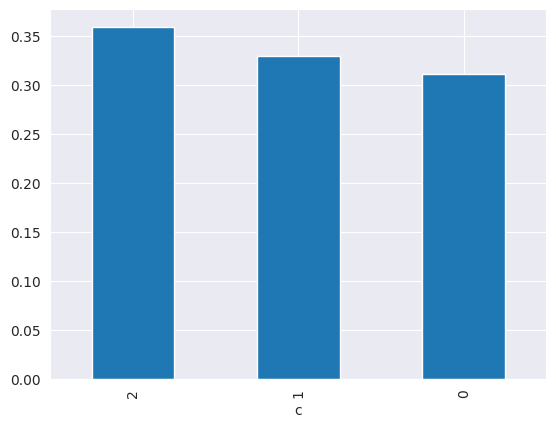

In [264]:
ds_cond['c'].value_counts(normalize=True).plot(kind='bar')

We kept the same proportions of labels, and we did not create imbalancy within the dataset
Let's compute the pairwise scatter of the first 5 attributes

In [265]:
columns = ds.columns[0:5].tolist() + ['c']

[]

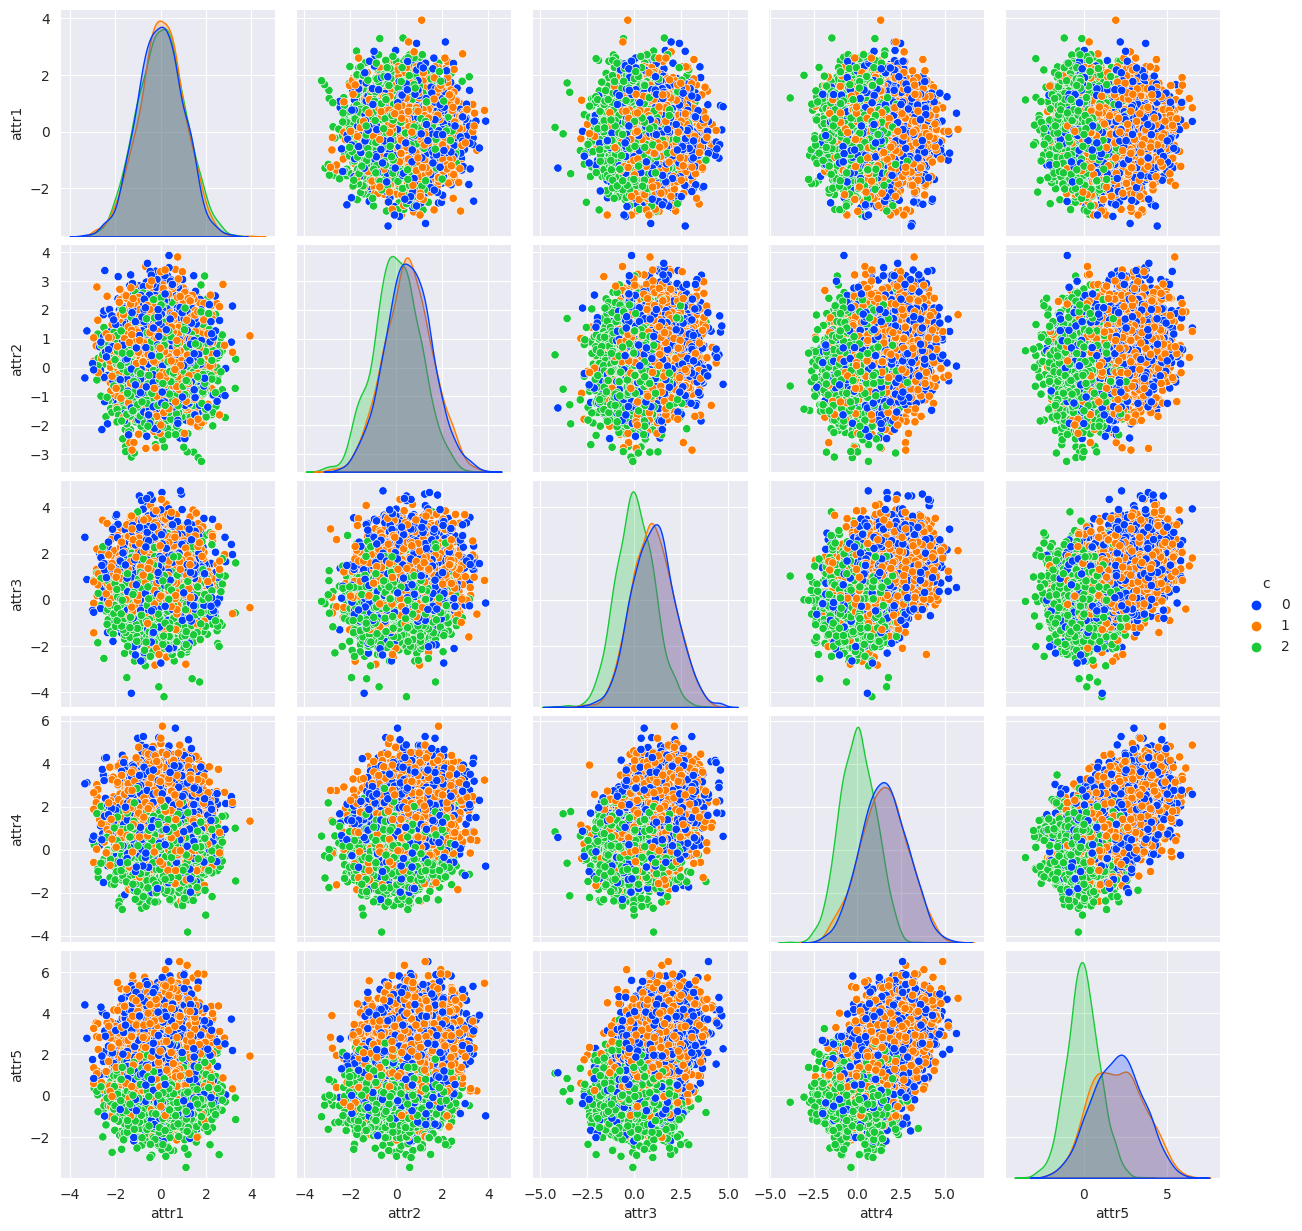

In [266]:
sns.pairplot(ds[columns], hue='c', palette='bright')
plt.plot()

[]

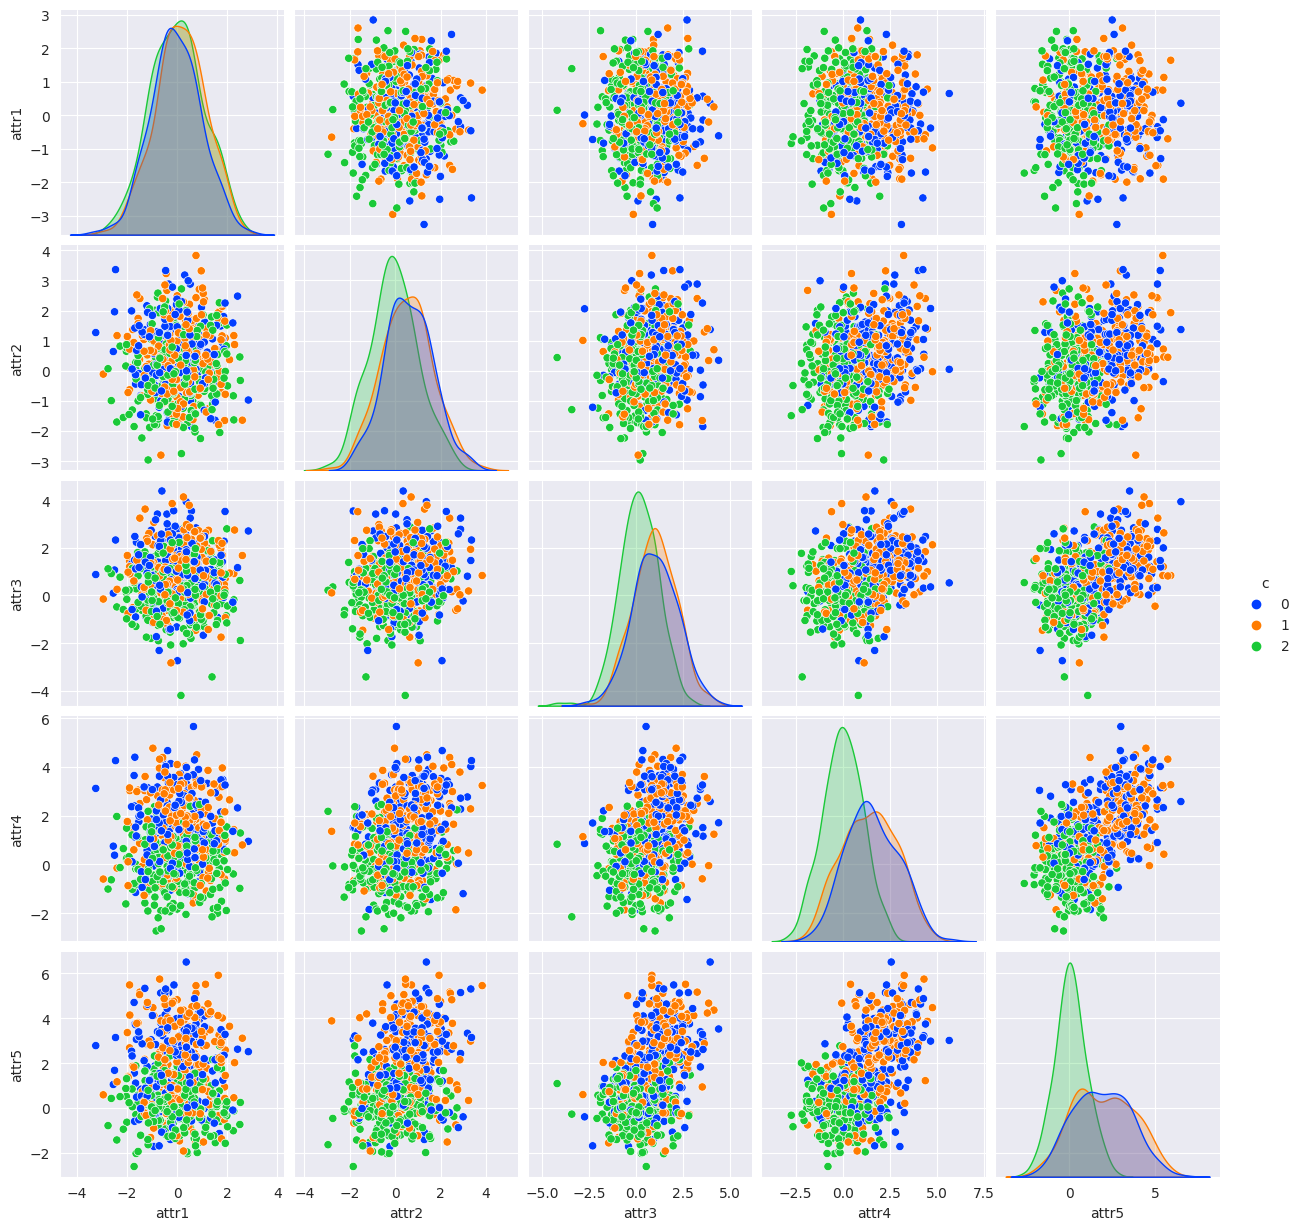

In [267]:
sns.pairplot(ds_cond[columns], hue='c', palette='bright')
plt.plot()

We will compare by fitting a 1-NN using the condensed training set and the control training set over the test set, and see the difference in term of performance.

In [268]:
model = KNeighborsClassifier(n_neighbors=1)

model.fit(X_train_control, y_train_control)

y_pred_control = model.predict(X_test)
model = KNeighborsClassifier(n_neighbors=1)
model.fit(X_train_cond, y_train_cond)
y_pred_cond = model.predict(X_test)

accuracy_control = accuracy_score(y_test, y_pred_control)
accuracy_cond = accuracy_score(y_test, y_pred_cond)

print(f'Accuracy on test for the control: {accuracy_control * 100:0.2f}%')
print(f'Accuracy on test after CNN: {accuracy_cond * 100:0.2f}%')
print(f'Difference: {accuracy_control*100 - accuracy_cond*100:0.2f}')

Accuracy on test for the control: 79.00%
Accuracy on test after CNN: 76.50%
Difference: 2.50


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_classification.py:233: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


We did suffer a loss of accuracy after performing a CNN, although the accuracy stays high, with a loss of 2% after CNN
Let's tune k and compare the results between the original training set and the condensed training set

In [269]:
optimal_k_cond = round(np.sqrt(X_train_cond.shape[0]))
optimal_k_cond

26

In [270]:
acc_cond, std_cond = tune(X_train_cond, y_train_cond.values.ravel(), k_min=1, k_max=100)

(682, 21)
0.467156862745098
0.5157289002557545
0.655392156862745
0.6730179028132992
0.6935208866155158
0.7390664961636828
0.7567135549872123
0.7670289855072464
0.7756606990622334
0.7699062233589087
0.7771099744245523
0.7815856777493606
0.79616368286445
0.7991901108269395
0.8035166240409207
0.7976982097186701
0.7903665814151747
0.8036018755328218
0.7903878942881499
0.8021952259164535
0.7904092071611253
0.7889386189258312
0.7903665814151748
0.8051150895140665
0.785997442455243
0.7962702472293265
0.7801364023870417
0.793307757885763
0.7786445012787724
0.7874040920716112
0.7815856777493606
0.7874254049445866
0.7800937766410911
0.7830349531116794
0.7845055413469736
0.7815217391304348
0.7830136402387041
0.7829710144927536
0.7917732310315431
0.7917945439045183
0.7917306052855925
0.802003410059676
0.7932011935208866
0.7961849957374254
0.79616368286445
0.802003410059676
0.7917519181585677
0.7946504688832053
0.7843137254901961
0.7946078431372549
0.7946078431372549
0.7975703324808183
0.7872975277

In [271]:
print(max(acc_cond), max(acc))
acc == acc_cond

0.8064791133844842 0.85825


False

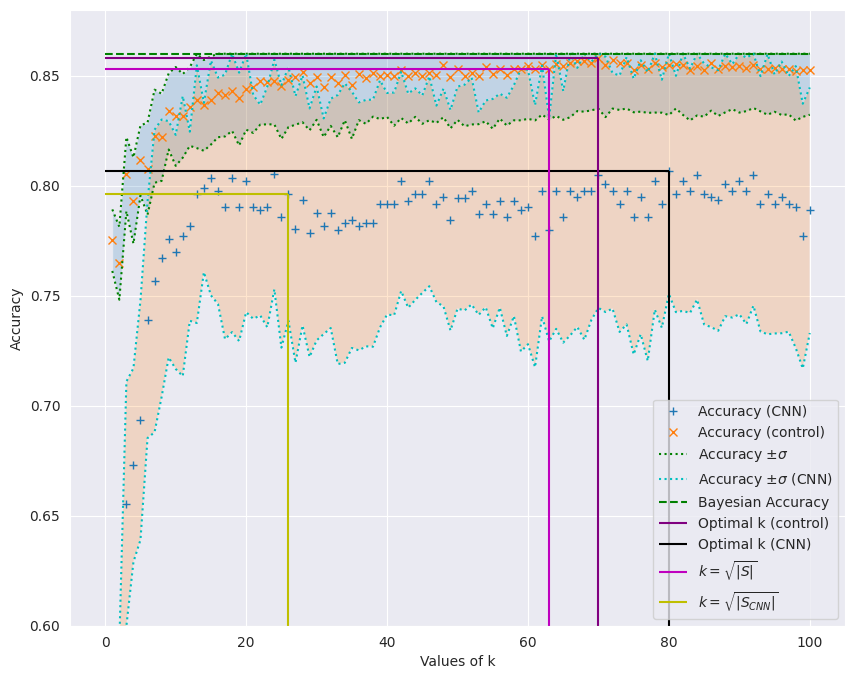

In [272]:

acc_plus_cond = np.add(acc_cond, std_cond)
acc_plus_cond[acc_plus_cond > 0.86] = 0.86
acc_minus_cond = np.subtract(acc_cond, std_cond)

fig, ax = plt.subplots(figsize=(10, 8))
xaxis = np.arange(0, 101, 1)
ax.plot(xaxis[1:], acc_cond[1:], '+', label='Accuracy (CNN)')
ax.plot(xaxis[1:], acc[1:], 'x', label='Accuracy (control)')

ax.plot(xaxis[1:], acc_plus[1:], 'g:',  label='Accuracy $\pm \sigma$')
ax.plot(xaxis[1:], acc_minus[1:], 'g:')
ax.fill_between(xaxis[1:], acc_plus[1:], acc_minus[1:], alpha=0.2)

ax.plot(xaxis[1:], acc_plus_cond[1:], 'c:', label='Accuracy $\pm \sigma$ (CNN)')
ax.plot(xaxis[1:], acc_minus_cond[1:], 'c:')
ax.fill_between(xaxis[1:], acc_plus_cond[1:], acc_minus_cond[1:], alpha=0.2)


ax.hlines(xmin=0, xmax=100, y=0.86, color='green', linestyle='--', label='Bayesian Accuracy')

ax.hlines(xmin=0, xmax=acc.index(max(acc)), y=max(acc), color='purple')
ax.hlines(xmin=0, xmax=theoretical_k, y=acc[theoretical_k], color='m')
ax.hlines(xmin=0, xmax=acc_cond.index(max(acc_cond)), y=max(acc_cond), color='k')
ax.hlines(xmin=0, xmax=optimal_k_cond, y=acc_cond[optimal_k_cond], color='y')
ax.vlines(ymin=0, ymax=max(acc), x=acc.index(max(acc)), color='purple', label='Optimal k (control)')
ax.vlines(ymin=0, ymax=max(acc_cond), x=acc_cond.index(max(acc_cond)), color='k', label='Optimal k (CNN)')
ax.vlines(ymin=0, ymax=acc[theoretical_k], x=theoretical_k, label='$k = \sqrt{|S|}$', color='m')
ax.vlines(ymin=0, ymax=acc_cond[optimal_k_cond], x=optimal_k_cond, label='$k =\sqrt{|S_{CNN}|}$', color='y')
plt.ylim(0.60, 0.88)
plt.xlabel('Values of k')
plt.ylabel("Accuracy")
plt.legend()
plt.show()

The accuracy of our model has a stronger standard deviation, and a lower accuracy. However the optimal k is lower, and computation time is faster.

The distribution of the points is the conserved, but the clouds of points are less dense, since the borders are enough to classify correctly (using 1-NN) the points from within the border.
Since there are clear overlaps between the different classes, even after reduction, the borders are not perfectly defined even after a CNN.

---

## PCA (Principal Component Analysis)

Method:

1. Normalize the data (0-mean value)
2. Covariance matrix
3. Eigenvectors and eigenvalues
4. Selection of principal components,
5. Data transformation (this step is to be applied to the test set as well)

In [273]:
def normalize(X: pd.DataFrame):
    mean = X.mean()
    std = X.std()
    normalized = (X - mean) / std
    return normalized

In [274]:
def find_eigen(X):
    cov = np.round(np.cov(X.T), 2)
    print(cov.shape)
    eig_val, eig_vec = np.linalg.eig(cov)
    indices = np.argsort(abs(eig_val))[::-1]
    eig_val = eig_val[indices]
    eig_vec = eig_vec[:,indices]
    print(eig_val.shape, eig_vec.shape)
    return eig_val, eig_vec

In [303]:
def explained_var(eig_val, min_exp_var = 0.97):
    sum_eig_val = np.sum(eig_val)
    explained_variance = eig_val/ sum_eig_val
    print("Explained variance ", explained_variance)
    cumulative_variance = np.cumsum(explained_variance)
    print("Cumulative variance ", cumulative_variance)
    
    plt.plot(np.arange(0, len(explained_variance), 1), cumulative_variance)
    plt.xlabel("Number of components")
    plt.ylabel("Explained variance")
    plt.show()
    
    # We will keep k components, s.t we have the minimal k that makes explained variance above min_exp_var
    return np.argmax(cumulative_variance >= min_exp_var) + 1

In [276]:
def transform(X:pd.DataFrame, eig_vectors):
    transformed_data = X @ eig_vectors
    return transformed_data

In [277]:
def pipeline_pca(X_train, X_test):
    X_norm = normalize(X_train)
    eig_val, eig_vec = find_eigen(X_norm)
    k = explained_var(eig_val)
    print
    features = {j: f'attr{i}' for j, i in enumerate(range(1, k+1))}
    eig_vec = eig_vec[:, :k]
    X_train_t = transform(X_train, eig_vec).rename(columns=features)
    X_test_t = transform(X_test, eig_vec).rename(columns=features)
    return X_train_t, X_test_t
    

(21, 21)
(21,) (21, 21)
Explained variance  [0.37737762 0.15545534 0.04917315 0.04662796 0.04220338 0.04179927
 0.03306016 0.03215815 0.02417119 0.02286709 0.02026641 0.01906415
 0.01744103 0.01702511 0.01667442 0.01578203 0.01548453 0.01494093
 0.01450889 0.01223804 0.01168114]
Cumulative variance  [0.37737762 0.53283296 0.58200611 0.62863407 0.67083745 0.71263672
 0.74569688 0.77785503 0.80202623 0.82489331 0.84515973 0.86422388
 0.88166491 0.89869002 0.91536444 0.93114646 0.94663099 0.96157192
 0.97608082 0.98831886 1.        ]


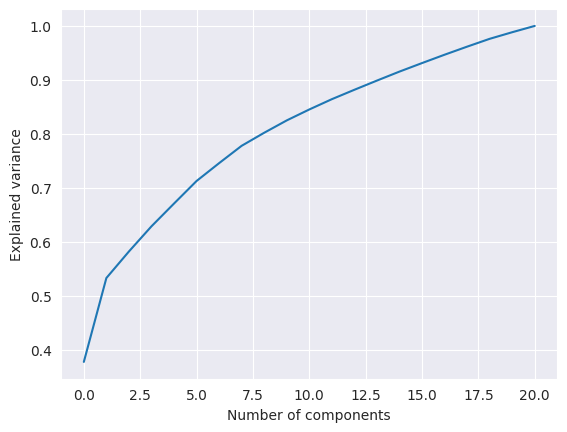

In [278]:
X_train_pca, X_test_pca = pipeline_pca(X_train, X_test)

In [279]:
print(X_test_pca.shape)

(1000, 19)


In [280]:
columns = X_train_pca.columns[0:5].tolist() + ['c']
ds_pca = pd.concat([X_train_pca, y_train_pca], axis=1)

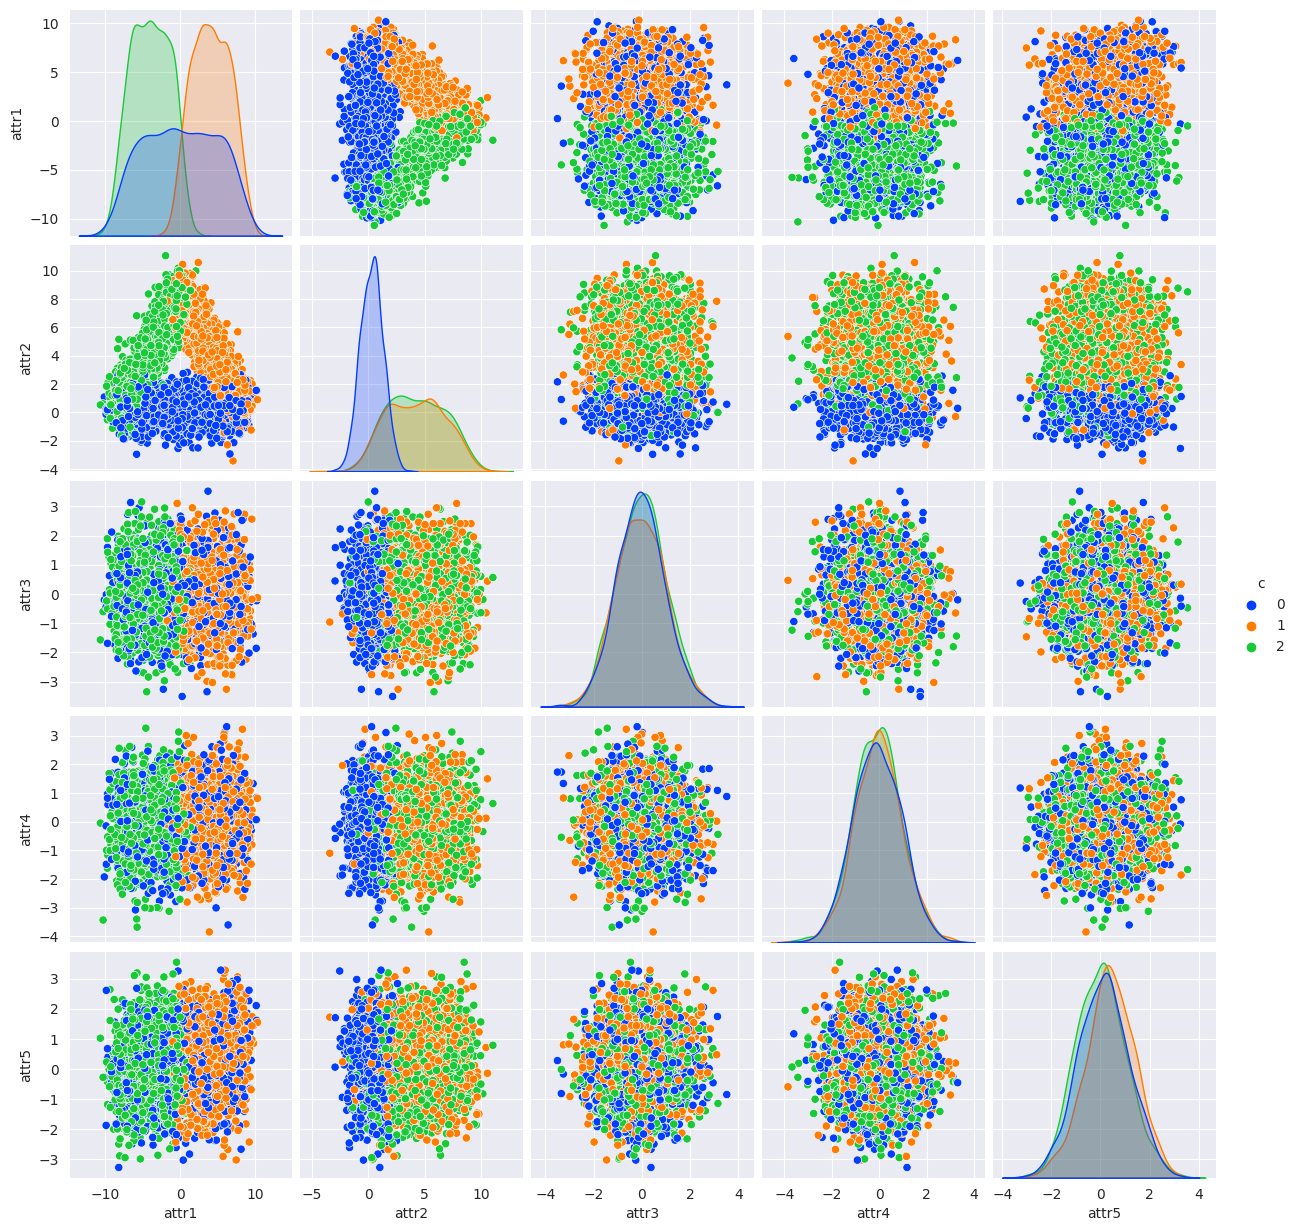

In [281]:
sns.pairplot(ds_pca[columns], hue='c', palette='bright')
plt.show()

[]

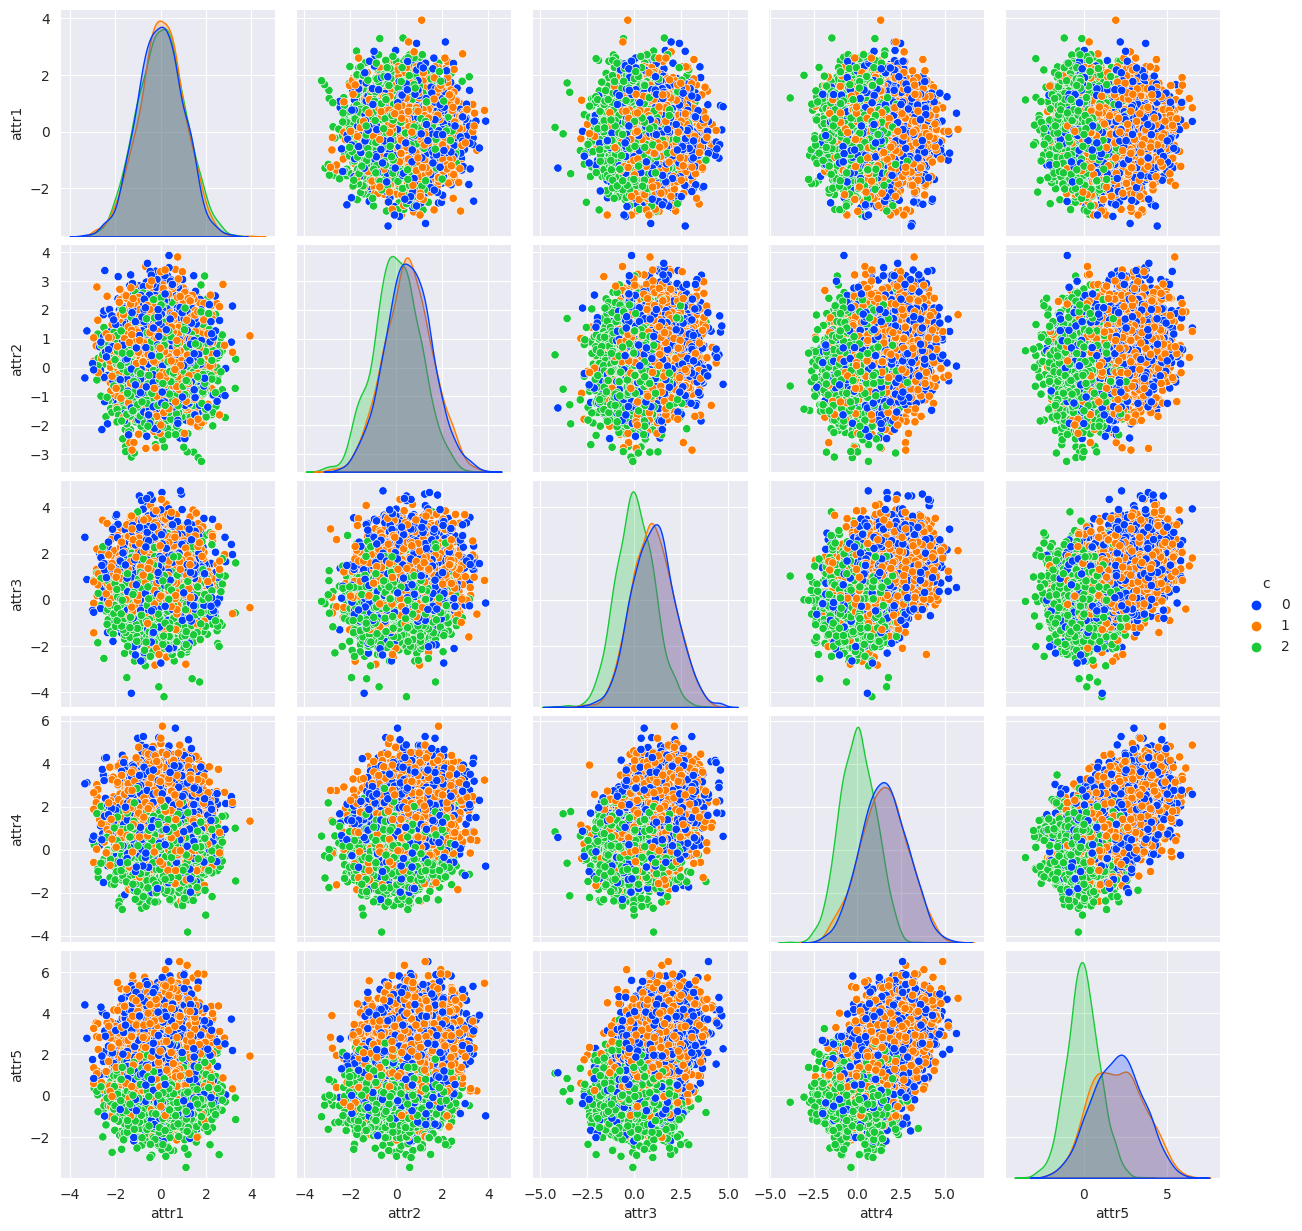

In [282]:
sns.pairplot(ds[columns], hue='c', palette='bright')
plt.plot()

In [283]:
X_train_pca.describe()

attr1        attr2        attr3        attr4        attr5  \
count  4000.000000  4000.000000  4000.000000  4000.000000  4000.000000   
mean     -0.042831     2.937878    -0.034561    -0.070005     0.178155   
std       4.782225     2.839238     1.016288     1.001772     1.039608   
min     -10.677345    -3.414142    -3.503683    -3.849917    -3.270045   
25%      -4.101718     0.602463    -0.731140    -0.757263    -0.525808   
50%      -0.177919     2.282057    -0.038742    -0.069887     0.178446   
75%       3.972582     5.258884     0.648182     0.589409     0.871896   
max      10.300819    11.051057     3.517130     3.310028     3.549081   

             attr6        attr7        attr8        attr9       attr10  \
count  4000.000000  4000.000000  4000.000000  4000.000000  4000.000000   
mean     -0.897867    -1.321765     0.597315    -0.787819    -2.699980   
std       1.024018     1.038929     1.073248     1.075526     1.006290   
min      -4.898460    -4.977781    -3.515328    -4.375754    -5.974853   
25%      -1.583569    -2.002115    -0.148587    -1.522717    -3.376791   
50%      -0.904233    -1.320743     0.562072    -0.795625    -2.708489   
75%      -0.204233    -0.622372     1.338726    -0.051497    -2.030744   
max       2.522191     2.647781     4.756897     2.737071     0.649772   

            attr11       attr12       attr13       attr14       attr15  \
count  4000.000000  4000.000000  4000.000000  4000.000000  4000.000000   
mean     -0.467943     0.084248    -2.692793    -2.551418     3.379038   
std       1.024726     1.012031     1.009867     0.998090     1.000187   
min      -4.281982    -4.411807    -6.198753    -6.442659     0.116530   
25%      -1.167509    -0.582202    -3.365883    -3.224233     2.695620   
50%      -0.465818     0.081193    -2.696209    -2.559541     3.384088   
75%       0.228627     0.751215    -2.026442    -1.871476     4.043766   
max       2.840469     4.290097     1.049703     0.639643     6.829368   

            attr16       attr17       attr18       attr19  
count  4000.000000  4000.000000  4000.000000  4000.000000  
mean      1.241560     3.637603    -1.428490     3.142109  
std       1.003676     1.015200     1.011073     0.998754  
min      -2.470778    -0.256339    -5.031898    -0.839872  
25%       0.577418     2.948404    -2.106287     2.468094  
50%       1.242957     3.645233    -1.421747     3.146122  
75%       1.923479     4.308898    -0.740781     3.818170  
max       5.311407     7.275009     1.962287     6.556483

---

## LDA (Linear Discriminant Analysis)

Method:

1.  Compute the mean vectors,
2.  Compute the within-class scatter matrix $S_W$
3.  Compute the between-class scatter matrix $S_B$
4.  Compute the matrix $S_W^{_1} \cdot S_B$ 
4.  Calculate the eigenvalues for the matrix $S_W^{_1} \cdot S_B$ (Linear Discriminants) 
5.  Select k best discriminants (k number of dimensions to keep)
6.  Transform (to be applied to the test set)

In [284]:
def scatter_matrix(X: pd.DataFrame, y: pd.DataFrame | pd.Series):
    if isinstance(y, pd.Series):
        y = y.to_frame()
    
    n_f = X.shape[1]
    classes = y['c'].unique()
    
    m = np.mean(X.values, axis=0)
    print(type(m))
    S_within = np.zeros((n_f, n_f))
    S_between = np.zeros((n_f, n_f))    
    for c in classes:
        X_c = X.loc[y['c'] == c]
        mean_c = np.mean(X_c.values, axis=0)
        
        S_within += (X_c - mean_c).T.dot((X_c - mean_c))
        
        n_c = X_c.shape[0]
        mean_diff = (mean_c - m).reshape(n_f, 1)
        
        S_between += n_c * (mean_diff).dot(mean_diff.T)
        # print(S_within)
    
    A = np.linalg.inv(S_within).dot(S_between)
    return A
    
    

In [285]:
def find_eigen_val(X):
    eig_val, eig_vec = np.linalg.eig(X)
    indices = np.argsort(abs(eig_val))[::-1]
    eig_val = np.real(eig_val[indices])
    eig_vec = np.real(eig_vec[:,indices])
    print(eig_val.shape, eig_vec.shape)
    return eig_val, eig_vec

In [286]:
def pipeline_lda(X, y, n_components = 18):
    A = scatter_matrix(X, y)
    
    eig_val, eig_vec = find_eigen_val(A)
    eig_vec = eig_vec[:, :n_components]
    return eig_val, eig_vec

In [287]:
eig_val_lda, eig_vec_lda = pipeline_lda(X_train, y_train)

<class 'numpy.ndarray'>
(21,) (21, 21)


In [288]:
features = {j: f'comp{i}' for j, i in enumerate(range(1, 19))}
X_train_lda = transform(X_train, eig_vec_lda).rename(columns=features)
X_test_lda = transform(X_test, eig_vec_lda).rename(columns=features)

In [289]:
X_train_lda.shape

(4000, 18)

In [290]:
X_test_lda

comp1     comp2     comp3     comp4     comp5     comp6     comp7  \
1501 -0.803355 -5.911387 -3.523049 -0.103943 -0.831287 -0.349134  1.545052   
2586  2.348465 -3.706118 -3.835955  2.669460  0.612425 -1.786583  0.317955   
2653  5.441561 -4.243741 -3.088637  0.820361 -0.006569  0.306819  0.691193   
1055 -2.138863  1.572159 -4.763460 -0.731005 -0.748106 -2.192627  1.620855   
705   3.069253 -2.844733 -4.399305  1.207280  0.047797 -2.875960  1.379969   
...        ...       ...       ...       ...       ...       ...       ...   
4711 -5.793518 -3.910207 -4.419899  0.515916  0.288657 -1.833449  0.591773   
2313  4.744821 -0.124990 -3.111523 -0.102374 -0.916983 -0.355679  1.700463   
3214  0.657360  1.007856 -5.263382  0.235985 -1.179776 -2.251347  1.927700   
2732 -3.602578 -1.612630 -5.059044  1.325367 -0.123246 -2.599942  1.814848   
1926 -1.204172 -5.883427 -4.600234  1.532432 -0.092641 -1.415364  0.886481   

         comp8     comp9    comp10    comp11    comp12    comp13    comp14  \
1501  1.545052 -0.694109 -0.694109 -0.004215  1.739293  1.739293  1.645120   
2586  0.317955 -0.914626 -0.914626  2.052404  0.638413  0.638413 -0.372608   
2653  0.691193  1.411284  1.411284  0.677261  0.193098  0.193098  0.403881   
1055  1.620855 -1.256352 -1.256352  1.048975  2.118636  2.118636  0.770507   
705   1.379969 -2.239042 -2.239042  1.631259  1.284039  1.284039  1.770479   
...        ...       ...       ...       ...       ...       ...       ...   
4711  0.591773 -1.741384 -1.741384  0.959196  1.029388  1.029388  0.529155   
2313  1.700463 -0.643812 -0.643812 -1.561891  3.413220  3.413220  3.527024   
3214  1.927700 -2.210354 -2.210354  3.196728  2.542990  2.542990  0.972213   
2732  1.814848 -1.702671 -1.702671  0.695347  2.240250  2.240250  2.021315   
1926  0.886481 -0.303422 -0.303422  1.315444  1.710646  1.710646 -0.266021   

        comp15    comp16    comp17    comp18  
1501  1.645120  2.824778 -0.272579 -0.272579  
2586 -0.372608  1.572084 -0.849702 -0.849702  
2653  0.403881  1.499903 -1.279320 -1.279320  
1055  0.770507  2.391892  0.809534  0.809534  
705   1.770479  1.655057 -0.439775 -0.439775  
...        ...       ...       ...       ...  
4711  0.529155  0.325764 -0.192934 -0.192934  
2313  3.527024  2.959974  1.531922  1.531922  
3214  0.972213  2.723454  0.984285  0.984285  
2732  2.021315  2.916652  0.745909  0.745909  
1926 -0.266021  1.845464 -0.960420 -0.960420  

[1000 rows x 18 columns]

In [291]:
ds_train_lda = pd.concat([X_train_lda, y_train], axis='columns')
columns = ds_train_lda.columns[0:5].to_list() + ['c']

[]

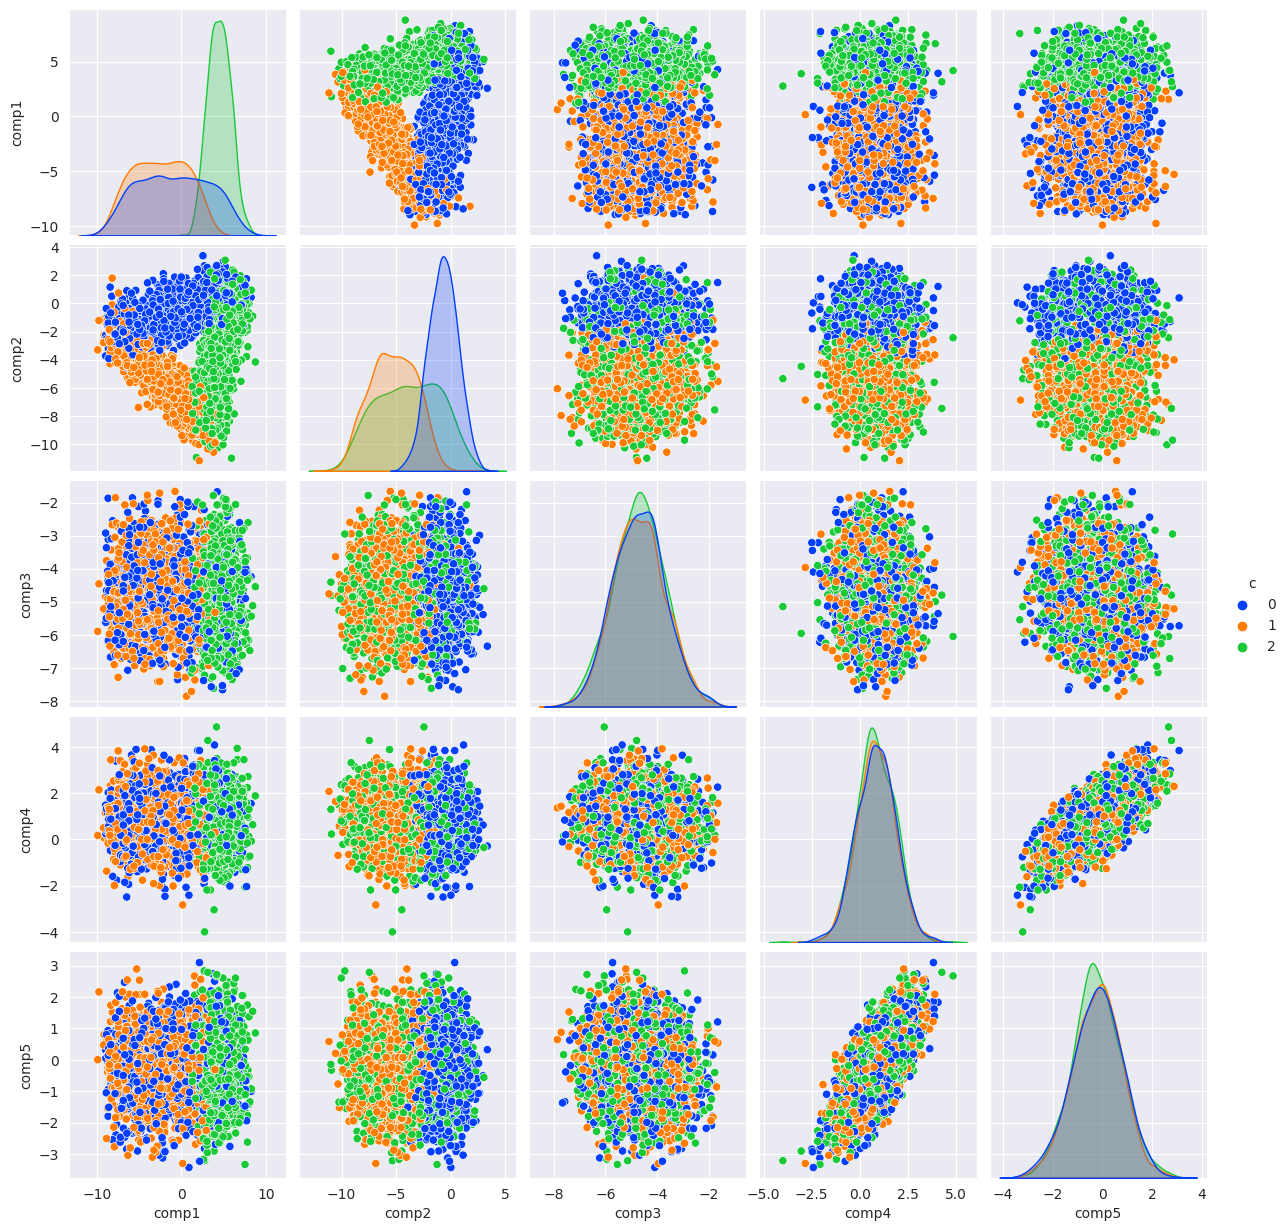

In [292]:
sns.pairplot(ds_train_lda[columns], hue='c', palette='bright')
plt.plot()

---

## Comparison between PCA / LDA / control

We will tune K for all the different training set by performing cross-validation, then compute their accuracy on their transformed test set.

In [293]:
acc_control, std_control = tune(X_train, y_train, k_min=1, k_max=100)
acc_pca, std_pca = tune(X_train_pca, y_train, k_min=1, k_max=100)
acc_lda, std_lda = tune(X_train_lda, y_train, k_min=1, k_max=100)

(4000, 21)
0.77525
0.76475
0.8052499999999998
0.79325
0.8115
0.8077500000000001
0.8225000000000001
0.8220000000000001
0.83375
0.8314999999999999
0.8317500000000001
0.836
0.8387499999999999
0.8365
0.8387499999999999
0.842
0.8412499999999999
0.843
0.8400000000000001
0.84375
0.84475
0.8474999999999999
0.8472500000000001
0.8474999999999999
0.8452500000000001
0.84825
0.8494999999999999
0.85175
0.8467500000000001
0.8494999999999999
0.8450000000000001
0.84925
0.8465
0.8504999999999999
0.8460000000000001
0.851
0.8487500000000001
0.85125
0.85
0.8505
0.8497499999999999
0.8524999999999998
0.85
0.85125
0.85
0.85125
0.8504999999999999
0.8547499999999999
0.8494999999999999
0.8532500000000001
0.8497499999999999
0.85125
0.8497499999999999
0.8539999999999999
0.851
0.853
0.8504999999999999
0.8530000000000001
0.853
0.8545
0.8532499999999998
0.8549999999999999
0.853
0.8554999999999999
0.8545
0.8557500000000001
0.8564999999999999
0.8564999999999999
0.8557500000000001
0.85825
0.8547499999999999
0.857
0.8557

In [294]:
acc_plus_control = np.add(acc_control, std_control)
# acc_plus_control[acc_plus_control > 0.86] = 0.86
acc_minus_control = np.subtract(acc_control, std_control)

acc_plus_pca = np.add(acc_pca, std_pca)
acc_minus_pca = np.subtract(acc_pca, std_pca)

acc_plus_lda = np.add(acc_lda, std_lda)
acc_minus_lda = np.subtract(acc_lda, std_lda)


In [295]:
max_control = max(acc_control)
max_control_index = acc_control.index(max_control)
related_std_control = std_control[max_control_index+1]

max_pca = max(acc_pca)
max_pca_index = acc_pca.index(max_pca)
related_std_pca = std_pca[max_pca_index+1]

max_lda = max(acc_lda)
max_lda_index = acc_lda.index(max_lda)
related_std_lda = std_lda[max_lda_index+1]

max_control_index, max_pca_index, max_lda_index

(70, 66, 42)

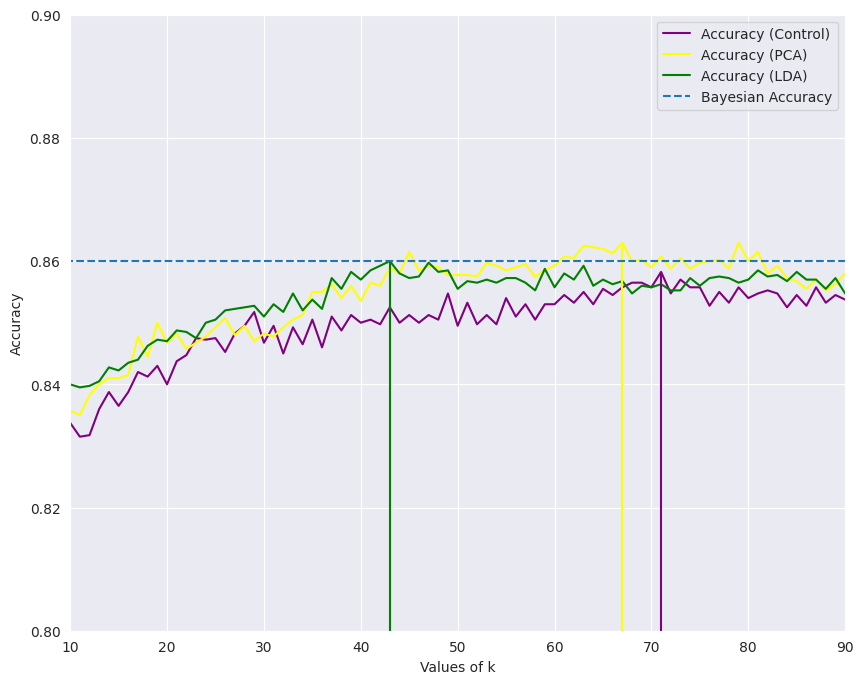

In [296]:
xaxis = np.arange(2, 102, 1)
plt.figure(figsize=(10, 8))
plt.plot(xaxis, acc_control[1:],color='purple', label='Accuracy (Control)')
# plt.plot(xaxis, acc_plus_control[1:], '--', color='purple')
# plt.plot(xaxis, acc_minus_control[1:], '--', color='purple')

plt.plot(xaxis, acc_pca[1:], color='yellow', label='Accuracy (PCA)')
# plt.plot(xaxis, acc_plus_pca[1:], '--', color='yellow')
# plt.plot(xaxis, acc_minus_pca[1:], '--', color='yellow')

plt.plot(xaxis, acc_lda[1:], color='green', label='Accuracy (LDA)')
# plt.plot(xaxis, acc_plus_lda[1:], '--', color='green')
# plt.plot(xaxis, acc_minus_lda[1:], '--', color='green')

# plt.fill_between(xaxis, acc_plus_control[1:], acc_minus_control[1:], color='purple', alpha=0.1, label='Accuracy $\pm\ \sigma$ (Control)')
# plt.fill_between(xaxis, acc_plus_pca[1:], acc_minus_pca[1:], color='yellow', alpha=0.1, label='Accuracy $\pm\ \sigma$ (PCA)')
# plt.fill_between(xaxis, acc_plus_lda[1:], acc_minus_lda[1:], color='green', alpha=0.1, label='Accuracy $\pm\ \sigma$ (LDA)')

plt.vlines(ymin=0, ymax=max_control, x=max_control_index+1, color='purple')

plt.vlines(ymin=0, ymax=max_pca, x=max_pca_index+1, color='yellow')
plt.vlines(ymin=0, ymax=max_lda, x = max_lda_index+1, color='green')
plt.hlines(xmin=0, xmax=100, y=0.86, linestyle='--', label='Bayesian Accuracy')

plt.ylim(0.80, 0.90)
plt.xlim(10, 90)
plt.xlabel('Values of k')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

Accuracy on the test set, using the respective optimal Ks:

In [297]:
X_train_control.shape, y_train_control.shape, X_train_pca.shape, y_train_pca.shape, X_train_lda.shape, y_train_lda.shape

((4000, 21), (4000,), (4000, 19), (4000,), (4000, 18), (4000,))

In [298]:
X_test.shape, y_test.shape, X_test_pca.shape, y_test_pca.shape, X_test_lda.shape, y_test_lda.shape

((1000, 21), (1000,), (1000, 19), (1000,), (1000, 18), (1000,))

In [299]:
X_test_lda.describe()

comp1        comp2        comp3        comp4        comp5  \
count  1000.000000  1000.000000  1000.000000  1000.000000  1000.000000   
mean      0.182650    -3.429843    -4.681003     0.770957    -0.273762   
std       4.230011     2.894316     0.984144     1.018403     1.006558   
min     -10.141286   -10.974129    -7.516101    -2.579194    -3.591611   
25%      -3.291776    -5.828430    -5.330549     0.077258    -0.943725   
50%       0.854366    -3.155846    -4.681282     0.778816    -0.224900   
75%       3.897201    -1.120420    -4.028743     1.517619     0.408759   
max       7.971007     2.908726    -1.259449     4.274210     2.726569   

             comp6        comp7        comp8        comp9       comp10  \
count  1000.000000  1000.000000  1000.000000  1000.000000  1000.000000   
mean     -1.925875     1.187440     1.187440    -1.241809    -1.241809   
std       1.000894     0.831960     0.831960     0.984817     0.984817   
min      -4.739773    -1.690887    -1.690887    -4.209795    -4.209795   
25%      -2.592378     0.631935     0.631935    -1.926306    -1.926306   
50%      -1.945610     1.162851     1.162851    -1.270863    -1.270863   
75%      -1.252014     1.699060     1.699060    -0.561289    -0.561289   
max       0.998034     4.077803     4.077803     1.804215     1.804215   

            comp11       comp12       comp13       comp14       comp15  \
count  1000.000000  1000.000000  1000.000000  1000.000000  1000.000000   
mean      0.977543     1.736118     1.736118     0.890573     0.890573   
std       1.013188     0.982504     0.982504     0.812312     0.812312   
min      -2.406451    -1.361273    -1.361273    -1.525782    -1.525782   
25%       0.293455     1.066199     1.066199     0.298906     0.298906   
50%       0.985500     1.721510     1.721510     0.899600     0.899600   
75%       1.632772     2.418682     2.418682     1.470267     1.470267   
max       3.782341     4.923091     4.923091     3.527024     3.527024   

            comp16       comp17       comp18  
count  1000.000000  1000.000000  1000.000000  
mean      2.149369    -0.042712    -0.042712  
std       1.005196     0.838642     0.838642  
min      -1.327042    -2.593248    -2.593248  
25%       1.453638    -0.600195    -0.600195  
50%       2.168444    -0.077473    -0.077473  
75%       2.824789     0.537179     0.537179  
max       5.820016     3.537389     3.537389

In [300]:
model = KNeighborsClassifier(n_neighbors=max_control_index+1)

model.fit(X_train_control, y_train_control)

y_pred_control = model.predict(X_test)

model = KNeighborsClassifier(n_neighbors=max_pca_index+1)
model.fit(X_train_pca, y_train_pca)
y_pred_pca = model.predict(X_test_pca)

model = KNeighborsClassifier(n_neighbors=max_lda_index+1)
model.fit(X_train_lda, y_train_lda)

y_pred_lda = model.predict(X_test_lda)

accuracy_control = accuracy_score(y_test, y_pred_control)
accuracy_pca = accuracy_score(y_test_pca, y_pred_pca)
accuracy_lda = accuracy_score(y_test_lda, y_pred_lda)

In [301]:
print(f'Accuracy on test for the control: {accuracy_control * 100:0.2f}% ± {related_std_control * 100:0.2f}%')
print(f'Accuracy on test after PCA: {accuracy_pca * 100:0.2f}% ± {related_std_pca * 100:0.2f}%')
print(f'Accuracy on test after LDA: {accuracy_lda * 100:0.2f}% ± {related_std_lda * 100:0.2f}%')
print(f'Difference control - PCA: {abs(accuracy_control*100 - accuracy_pca*100):0.2f}%')
print(f'Difference control - LDA: {abs(accuracy_control*100 - accuracy_lda*100):0.2f}%')

Accuracy on test for the control: 86.10% ± 2.36%
Accuracy on test after PCA: 86.20% ± 2.35%
Accuracy on test after LDA: 86.90% ± 1.88%
Difference control - PCA: 0.10%
Difference control - LDA: 0.80%


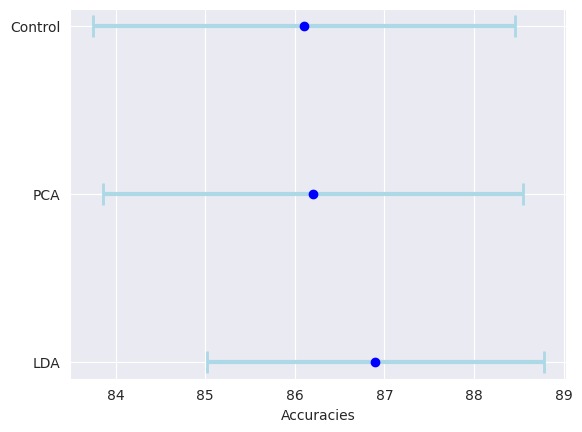

In [302]:
accuracies = [accuracy_control, accuracy_pca, accuracy_lda]
accuracies = np.multiply(accuracies, 100)

stddevs = [related_std_control, related_std_pca, related_std_lda]
stddevs = np.multiply(stddevs, 100)
labels = ['Control', 'PCA', 'LDA']

y_pos = range(len(labels))

plt.errorbar(accuracies, y_pos, xerr=stddevs, fmt='o', color='blue', ecolor='lightblue', elinewidth=3, capsize=8, barsabove=False, capthick=2)
# plt.vlines(ymin=0, ymax=2, x=86)
plt.yticks(y_pos, labels)

plt.xlabel('Accuracies')
plt.gca().invert_yaxis()
plt.show()